# Veri Seti Hikayesi

### Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

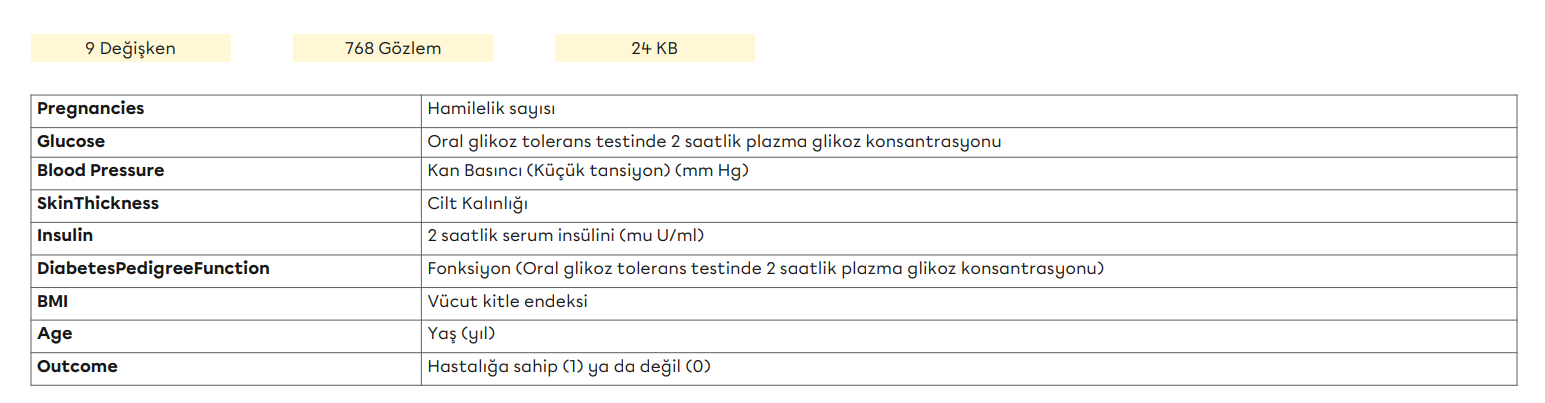

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import LocalOutlierFactor,KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
pd.set_option("display.max_columns",None)
pd.set_option("display.width",600)
pd.set_option("display.max_rows",600)
pd.set_option("display.float_format",lambda x:"%.2f" %x)

In [3]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [4]:
def dataFrame_summary(dataframe,head=5):
    print("######## SHAPE #######")
    print(dataframe.shape)
    print("######## TYPES #######")
    print(dataframe.dtypes)
    print("######## HEAD ########")
    print(dataframe.head(head))
    print("######## TAIL ########")
    print(dataframe.tail())
    print("######## NA ##########")
    print(dataframe.isnull().sum())

In [5]:
dataFrame_summary(df,10)

######## SHAPE #######
(768, 9)
######## TYPES #######
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
######## HEAD ########
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.60                      0.63   50        1
1            1       85             66             29        0 26.60                      0.35   31        0
2            8      183             64              0        0 23.30                      0.67   32        1
3            1       89             66             23       94 28.10                      0.17   21        0
4            0      137             40 

In [6]:
def grab_col_names(dataframe,cat_th=10,car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype !="O"]
    
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtype == "O" and dataframe[col].nunique() > car_th]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtype != "O" and dataframe[col].nunique() < cat_th]
    
    cat_cols =  cat_cols + num_but_cat
    
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"cat_cols : {len(cat_cols)}")
    print(f"num_cols : {len(num_cols)}")
    print(f"cat_but_car : {len(cat_but_car)}")
    print(f"num_but_cat : {len(num_but_cat)}")
    
    return cat_cols,num_cols,cat_but_car

In [7]:
cat_cols,num_cols,cat_but_car=grab_col_names(df)

cat_cols : 1
num_cols : 8
cat_but_car : 0
num_but_cat : 1


In [8]:
cat_cols

['Outcome']

In [9]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [10]:
cat_but_car

[]

In [11]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.00,3.85,3.37,0.00,1.00,3.00,6.00,17.00
Glucose,768.00,120.89,31.97,0.00,99.00,117.00,140.25,199.00
BloodPressure,768.00,69.11,19.36,0.00,62.00,72.00,80.00,122.00
SkinThickness,768.00,20.54,15.95,0.00,0.00,23.00,32.00,99.00
Insulin,768.00,79.80,115.24,0.00,0.00,30.50,127.25,846.00
BMI,768.00,31.99,7.88,0.00,27.30,32.00,36.60,67.10
DiabetesPedigreeFunction,768.00,0.47,0.33,0.08,0.24,0.37,0.63,2.42
Age,768.00,33.24,11.76,21.00,24.00,29.00,41.00,81.00


In [12]:
df.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [13]:
def cat_summary(dataframe,cat_col,plot=True):
    print(pd.DataFrame({cat_col : dataframe[cat_col].value_counts(),
                        "Ratio" : dataframe[cat_col].value_counts() / len(dataframe[cat_col] * 100)}))
    if plot:
        sns.countplot(data=dataframe,x=dataframe[cat_col])
        plt.show(block=True)

   Outcome  Ratio
0      500   0.65
1      268   0.35


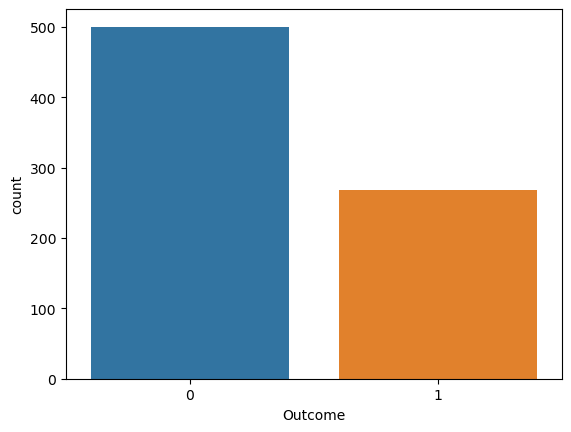

In [14]:
for col in cat_cols:
    cat_summary(df,col)

In [15]:
def num_summary(dataframe,num_col,plot=True):
    print(f"{num_col} has Na:{dataframe[num_col].isnull().any()} \n")
    print(pd.DataFrame({num_col : dataframe[num_col].describe().T}))
    
    if plot:
        sns.histplot(data=dataframe,x=dataframe[num_col])
        plt.grid()
        plt.show(block=True)

Pregnancies has Na:False 

       Pregnancies
count       768.00
mean          3.85
std           3.37
min           0.00
25%           1.00
50%           3.00
75%           6.00
max          17.00


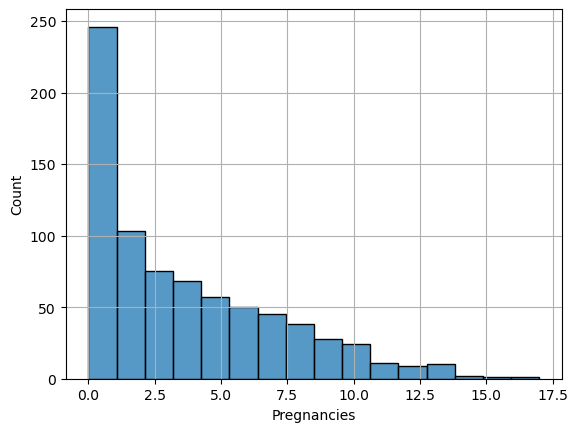

Glucose has Na:False 

       Glucose
count   768.00
mean    120.89
std      31.97
min       0.00
25%      99.00
50%     117.00
75%     140.25
max     199.00


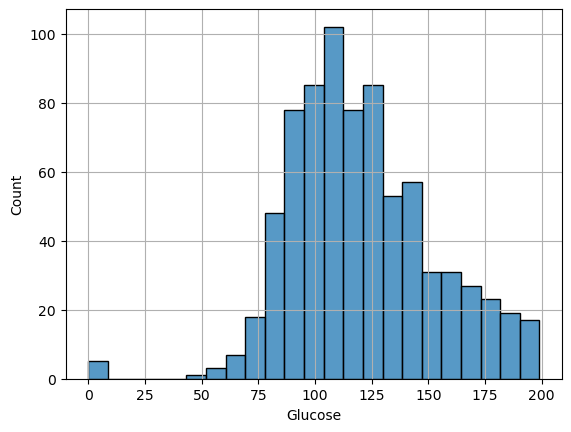

BloodPressure has Na:False 

       BloodPressure
count         768.00
mean           69.11
std            19.36
min             0.00
25%            62.00
50%            72.00
75%            80.00
max           122.00


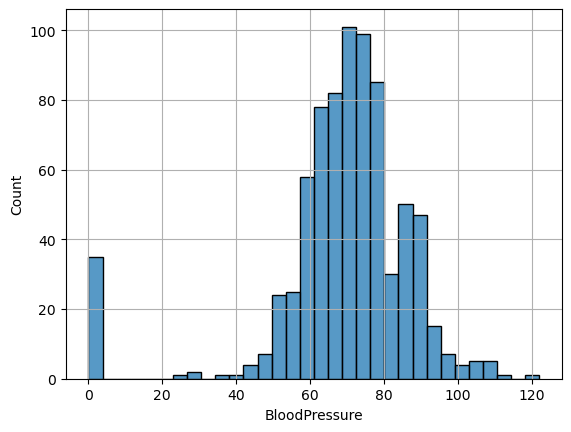

SkinThickness has Na:False 

       SkinThickness
count         768.00
mean           20.54
std            15.95
min             0.00
25%             0.00
50%            23.00
75%            32.00
max            99.00


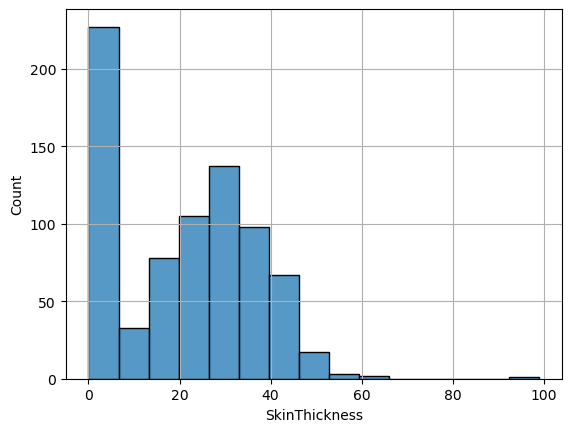

Insulin has Na:False 

       Insulin
count   768.00
mean     79.80
std     115.24
min       0.00
25%       0.00
50%      30.50
75%     127.25
max     846.00


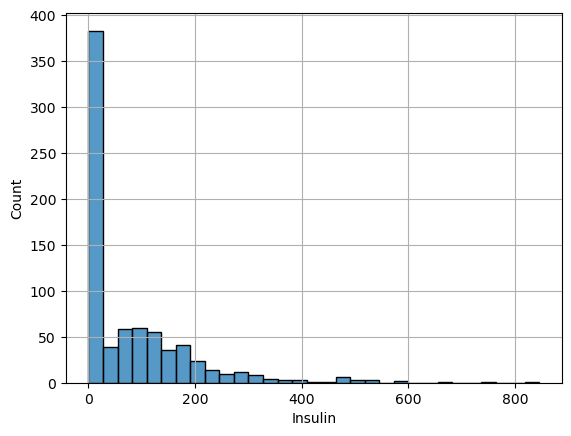

BMI has Na:False 

         BMI
count 768.00
mean   31.99
std     7.88
min     0.00
25%    27.30
50%    32.00
75%    36.60
max    67.10


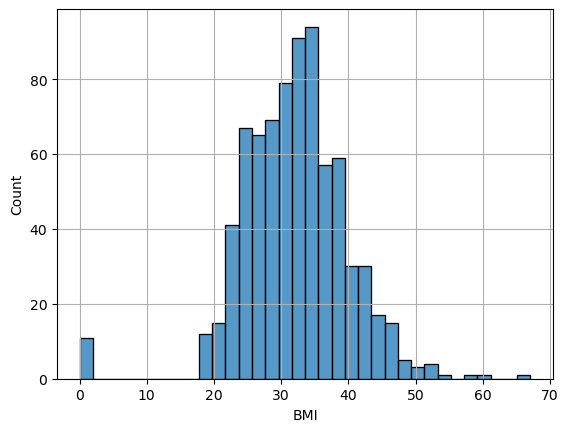

DiabetesPedigreeFunction has Na:False 

       DiabetesPedigreeFunction
count                    768.00
mean                       0.47
std                        0.33
min                        0.08
25%                        0.24
50%                        0.37
75%                        0.63
max                        2.42


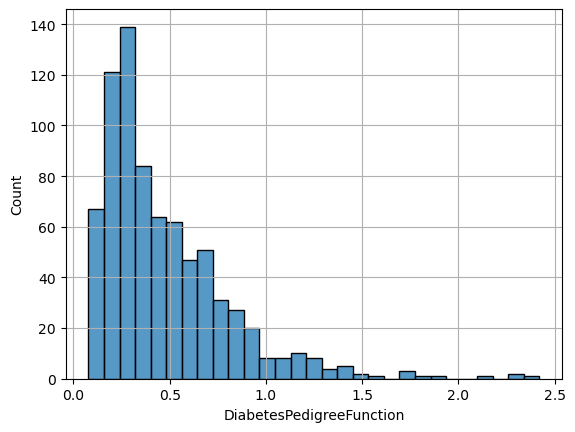

Age has Na:False 

         Age
count 768.00
mean   33.24
std    11.76
min    21.00
25%    24.00
50%    29.00
75%    41.00
max    81.00


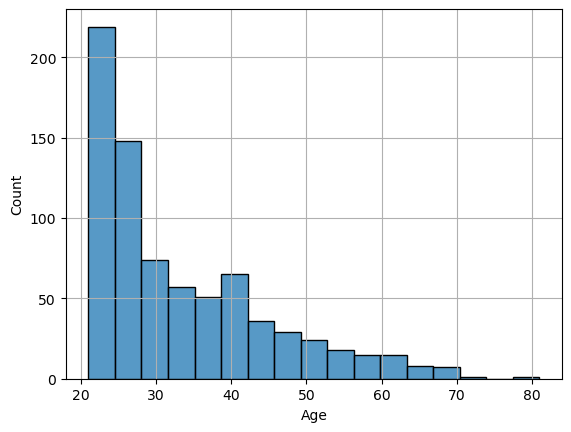

In [16]:
for col in num_cols:
    num_summary(df,col)

In [17]:
def num_cols_mean(dataframe,target,col_name):
    print(pd.DataFrame({col_name : dataframe.groupby(target)[col_name].mean()}))
    print("############")

In [18]:
for col in num_cols:
    num_cols_mean(df,"Outcome",col)

         Pregnancies
Outcome             
0               3.30
1               4.87
############
         Glucose
Outcome         
0         109.98
1         141.26
############
         BloodPressure
Outcome               
0                68.18
1                70.82
############
         SkinThickness
Outcome               
0                19.66
1                22.16
############
         Insulin
Outcome         
0          68.79
1         100.34
############
          BMI
Outcome      
0       30.30
1       35.14
############
         DiabetesPedigreeFunction
Outcome                          
0                            0.43
1                            0.55
############
          Age
Outcome      
0       31.19
1       37.07
############


In [19]:
missing_cols = [col for col in df.columns if df[df[col] == 0].any(axis=None) > 0 and col not in ["Pregnancies","Outcome"]]
missing_cols

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [20]:
for col in missing_cols:
    df.loc[df[col] == 0,col] = np.nan

In [21]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [22]:
def fill_with_mean(dataframe,col_name):
    dataframe[col_name].fillna(dataframe[col_name].mean(),inplace=True)

In [23]:
def fill_with_target_mean(dataframe,target,col_name):
    dataframe[col_name].fillna(dataframe.groupby(target)[col_name].transform("mean"),inplace=True)

In [24]:
for col in ["Glucose","BloodPressure","SkinThickness","BMI"]:
    fill_with_mean(df,col)

In [25]:
fill_with_target_mean(df,"Outcome","Insulin")

In [26]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [27]:
def outlier_th(dataframe,col_name,q1=0.25,q3=0.75,plot=False):
    quar1 = dataframe[col_name].quantile(q1)
    quar3 = dataframe[col_name].quantile(q3)
    
    iqr = quar3 - quar1
    
    lowLimit = quar1 - 1.5 * iqr
    upLimit = quar3 + 1.5 * iqr
    
    if plot:
        sns.boxplot(x=dataframe[col_name])
        plt.show(block=True)
    
    return lowLimit,upLimit

In [28]:
def num_of_outliers(dataframe,col_name,q1=0.25,q3=0.75):
    quar1 = dataframe[col_name].quantile(q1)
    quar3 = dataframe[col_name].quantile(q3)
    
    iqr = quar3 - quar1
    
    lowLimit = quar1 - 1.5 * iqr
    upLimit = quar3 + 1.5 * iqr
    
    outliers = dataframe[(dataframe[col_name] < lowLimit) | (dataframe[col_name] > upLimit)]
    
    return len(outliers)

In [29]:
def outliers_control(dataframe,col_name,q1=0.25,q3=0.75):
    quar1 = dataframe[col_name].quantile(q1)
    quar3 = dataframe[col_name].quantile(q3)
    
    iqr = quar3 - quar1
    
    lowLimit = quar1 - 1.5 * iqr
    upLimit = quar3 + 1.5 * iqr
    
    if dataframe[(dataframe[col_name] < lowLimit) | (dataframe[col_name] > upLimit)].any(axis=None):
        return True
    else:
        return False

In [30]:
def outlier_summary(dataframe,num_cols,q1=0.25,q3=0.75):
    for col in num_cols:
        print(f"{col} threshold deger aralığı :",outlier_th(dataframe,col,q1,q3,plot=True))
        print(f"############# {col} DESCRİBE ###########")
        print(dataframe[col].describe())
        print("########################")
        print(f"{col} has outlier : {outliers_control(dataframe,col,q1,q3)}")
        print(f"{col} num of outliers {num_of_outliers(dataframe,col,q1,q3)}")

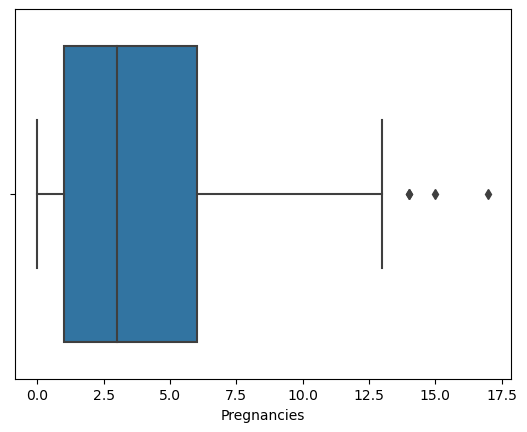

Pregnancies threshold deger aralığı : (-6.5, 13.5)
############# Pregnancies DESCRİBE ###########
count   768.00
mean      3.85
std       3.37
min       0.00
25%       1.00
50%       3.00
75%       6.00
max      17.00
Name: Pregnancies, dtype: float64
########################
Pregnancies has outlier : True
Pregnancies num of outliers 4


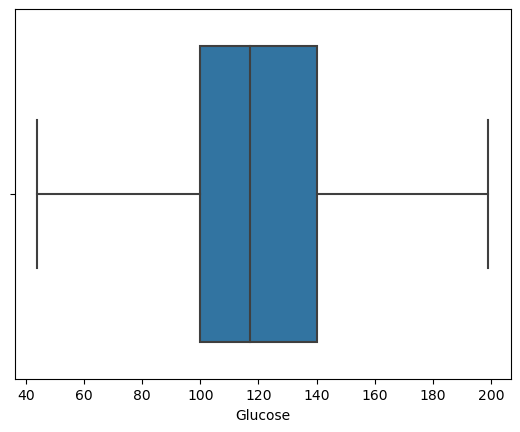

Glucose threshold deger aralığı : (39.0, 201.0)
############# Glucose DESCRİBE ###########
count   768.00
mean    121.69
std      30.44
min      44.00
25%      99.75
50%     117.00
75%     140.25
max     199.00
Name: Glucose, dtype: float64
########################
Glucose has outlier : False
Glucose num of outliers 0


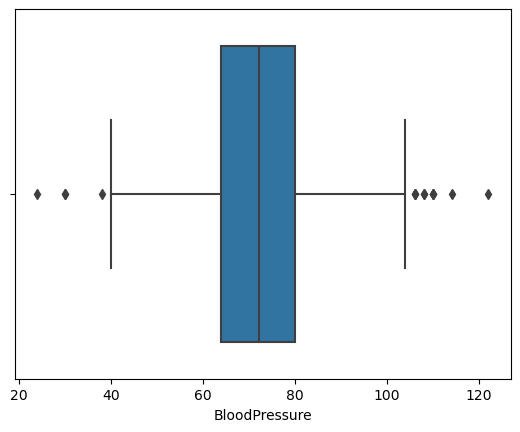

BloodPressure threshold deger aralığı : (40.0, 104.0)
############# BloodPressure DESCRİBE ###########
count   768.00
mean     72.41
std      12.10
min      24.00
25%      64.00
50%      72.20
75%      80.00
max     122.00
Name: BloodPressure, dtype: float64
########################
BloodPressure has outlier : True
BloodPressure num of outliers 14


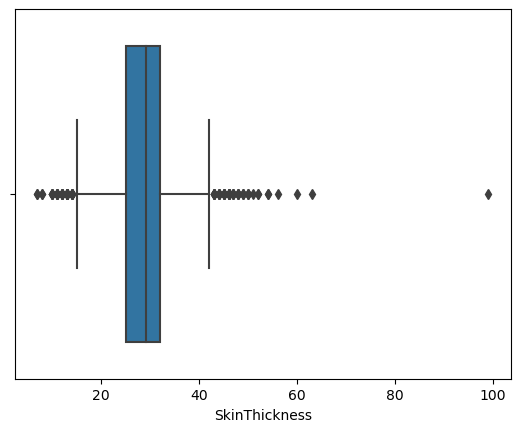

SkinThickness threshold deger aralığı : (14.5, 42.5)
############# SkinThickness DESCRİBE ###########
count   768.00
mean     29.15
std       8.79
min       7.00
25%      25.00
50%      29.15
75%      32.00
max      99.00
Name: SkinThickness, dtype: float64
########################
SkinThickness has outlier : True
SkinThickness num of outliers 87


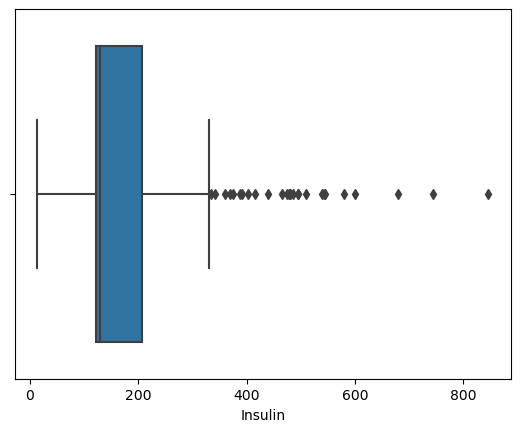

Insulin threshold deger aralığı : (-6.519230769230774, 334.86538461538464)
############# Insulin DESCRİBE ###########
count   768.00
mean    157.00
std      88.86
min      14.00
25%     121.50
50%     130.29
75%     206.85
max     846.00
Name: Insulin, dtype: float64
########################
Insulin has outlier : True
Insulin num of outliers 27


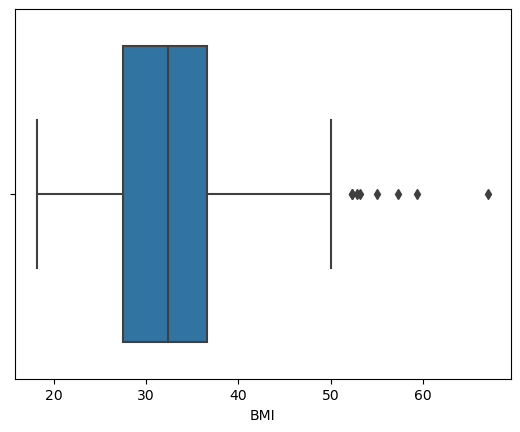

BMI threshold deger aralığı : (13.849999999999998, 50.25)
############# BMI DESCRİBE ###########
count   768.00
mean     32.46
std       6.88
min      18.20
25%      27.50
50%      32.40
75%      36.60
max      67.10
Name: BMI, dtype: float64
########################
BMI has outlier : True
BMI num of outliers 8


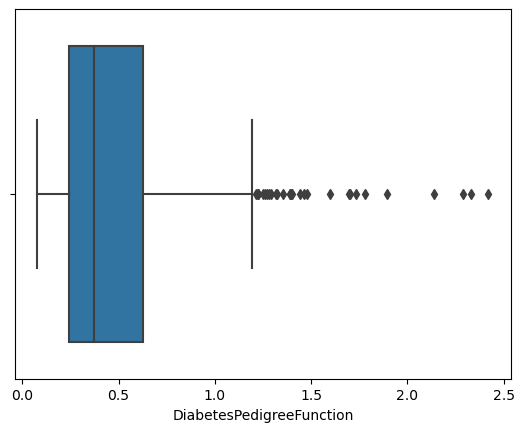

DiabetesPedigreeFunction threshold deger aralığı : (-0.32999999999999996, 1.2)
############# DiabetesPedigreeFunction DESCRİBE ###########
count   768.00
mean      0.47
std       0.33
min       0.08
25%       0.24
50%       0.37
75%       0.63
max       2.42
Name: DiabetesPedigreeFunction, dtype: float64
########################
DiabetesPedigreeFunction has outlier : True
DiabetesPedigreeFunction num of outliers 29


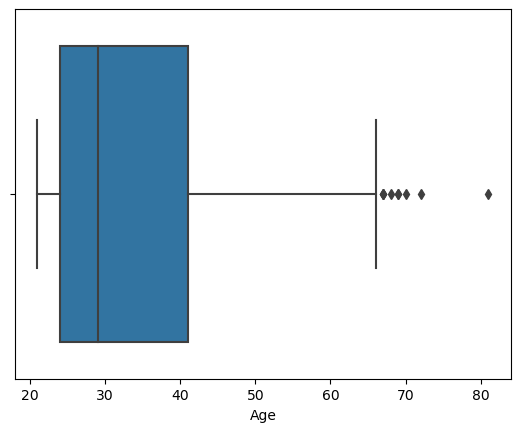

Age threshold deger aralığı : (-1.5, 66.5)
############# Age DESCRİBE ###########
count   768.00
mean     33.24
std      11.76
min      21.00
25%      24.00
50%      29.00
75%      41.00
max      81.00
Name: Age, dtype: float64
########################
Age has outlier : True
Age num of outliers 9


In [31]:
outlier_summary(df,num_cols)

In [32]:
def replace_with_th(dataframe,col_name):
    lowLimit,upLimit = outlier_th(dataframe,col_name)
    
    dataframe.loc[dataframe[col_name] < lowLimit,col_name] = lowLimit
    dataframe.loc[dataframe[col_name] > upLimit,col_name] = upLimit

In [33]:
def remove_outlier(dataframe,col_name):
    lowLimit,upLimit = outlier_th(dataframe,col_name)
    
    new_df = dataframe.loc[~((dataframe[col_name] < lowLimit) | (dataframe[col_name] > upLimit))]
    
    return new_df

In [34]:
def find_outliers_variable(dataframe,num_cols):
    outliers_list = [col for col in num_cols if num_of_outliers(dataframe,col) > 0]
    
    return outliers_list

In [35]:
outList = find_outliers_variable(df,num_cols)

In [36]:
for col in outList:
    replace_with_th(df,col)

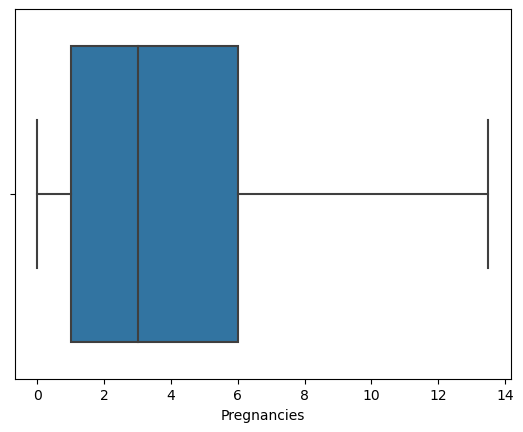

Pregnancies threshold deger aralığı : (-6.5, 13.5)
############# Pregnancies DESCRİBE ###########
count   768.00
mean      3.84
std       3.34
min       0.00
25%       1.00
50%       3.00
75%       6.00
max      13.50
Name: Pregnancies, dtype: float64
########################
Pregnancies has outlier : False
Pregnancies num of outliers 0


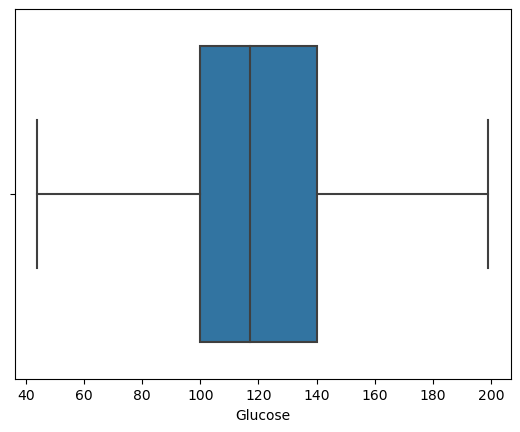

Glucose threshold deger aralığı : (39.0, 201.0)
############# Glucose DESCRİBE ###########
count   768.00
mean    121.69
std      30.44
min      44.00
25%      99.75
50%     117.00
75%     140.25
max     199.00
Name: Glucose, dtype: float64
########################
Glucose has outlier : False
Glucose num of outliers 0


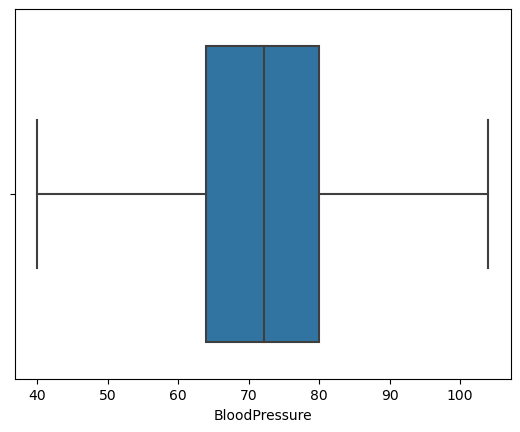

BloodPressure threshold deger aralığı : (40.0, 104.0)
############# BloodPressure DESCRİBE ###########
count   768.00
mean     72.38
std      11.70
min      40.00
25%      64.00
50%      72.20
75%      80.00
max     104.00
Name: BloodPressure, dtype: float64
########################
BloodPressure has outlier : False
BloodPressure num of outliers 0


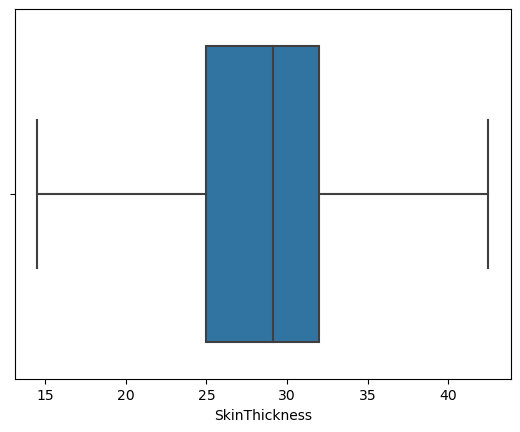

SkinThickness threshold deger aralığı : (14.5, 42.5)
############# SkinThickness DESCRİBE ###########
count   768.00
mean     28.91
std       7.44
min      14.50
25%      25.00
50%      29.15
75%      32.00
max      42.50
Name: SkinThickness, dtype: float64
########################
SkinThickness has outlier : False
SkinThickness num of outliers 0


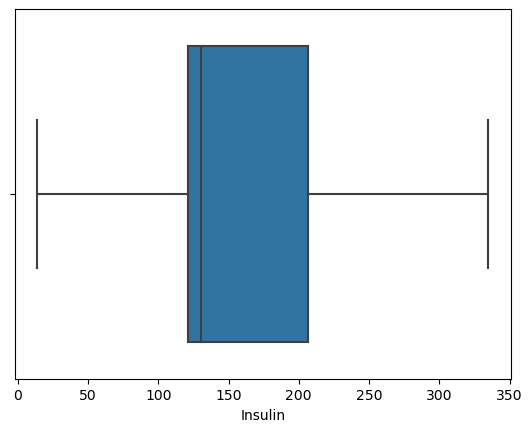

Insulin threshold deger aralığı : (-6.519230769230774, 334.86538461538464)
############# Insulin DESCRİBE ###########
count   768.00
mean    151.51
std      67.47
min      14.00
25%     121.50
50%     130.29
75%     206.85
max     334.87
Name: Insulin, dtype: float64
########################
Insulin has outlier : False
Insulin num of outliers 0


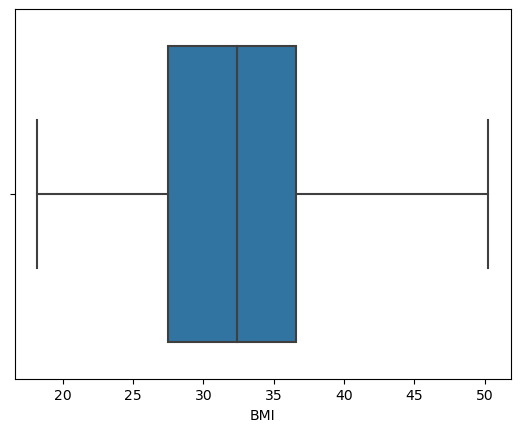

BMI threshold deger aralığı : (13.849999999999998, 50.25)
############# BMI DESCRİBE ###########
count   768.00
mean     32.40
std       6.67
min      18.20
25%      27.50
50%      32.40
75%      36.60
max      50.25
Name: BMI, dtype: float64
########################
BMI has outlier : False
BMI num of outliers 0


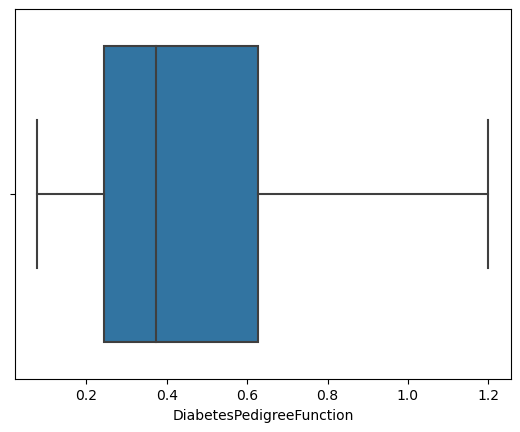

DiabetesPedigreeFunction threshold deger aralığı : (-0.32999999999999996, 1.2)
############# DiabetesPedigreeFunction DESCRİBE ###########
count   768.00
mean      0.46
std       0.29
min       0.08
25%       0.24
50%       0.37
75%       0.63
max       1.20
Name: DiabetesPedigreeFunction, dtype: float64
########################
DiabetesPedigreeFunction has outlier : False
DiabetesPedigreeFunction num of outliers 0


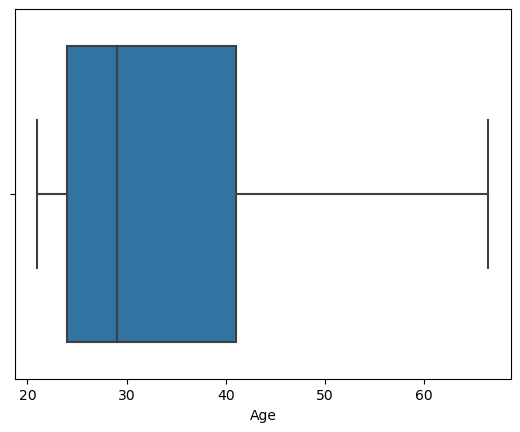

Age threshold deger aralığı : (-1.5, 66.5)
############# Age DESCRİBE ###########
count   768.00
mean     33.20
std      11.63
min      21.00
25%      24.00
50%      29.00
75%      41.00
max      66.50
Name: Age, dtype: float64
########################
Age has outlier : False
Age num of outliers 0


In [37]:
outlier_summary(df,num_cols)

In [38]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.00,3.84,3.34,0.00,1.00,3.00,6.00,13.50
Glucose,768.00,121.69,30.44,44.00,99.75,117.00,140.25,199.00
BloodPressure,768.00,72.38,11.70,40.00,64.00,72.20,80.00,104.00
SkinThickness,768.00,28.91,7.44,14.50,25.00,29.15,32.00,42.50
Insulin,768.00,151.51,67.47,14.00,121.50,130.29,206.85,334.87
BMI,768.00,32.40,6.67,18.20,27.50,32.40,36.60,50.25
DiabetesPedigreeFunction,768.00,0.46,0.29,0.08,0.24,0.37,0.63,1.20
Age,768.00,33.20,11.63,21.00,24.00,29.00,41.00,66.50


In [39]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [40]:
corr = df.corr()
corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.00,0.13,0.21,0.11,0.14,0.03,-0.02,0.55,0.22
Glucose,0.13,1.00,0.22,0.18,0.53,0.23,0.12,0.27,0.49
BloodPressure,0.21,0.22,1.00,0.21,0.13,0.29,0.01,0.33,0.17
SkinThickness,0.11,0.18,0.21,1.00,0.22,0.56,0.07,0.13,0.22
Insulin,0.14,0.53,0.13,0.22,1.00,0.27,0.11,0.20,0.50
BMI,0.03,0.23,0.29,0.56,0.27,1.00,0.14,0.04,0.31
DiabetesPedigreeFunction,-0.02,0.12,0.01,0.07,0.11,0.14,1.00,0.05,0.18
Age,0.55,0.27,0.33,0.13,0.20,0.04,0.05,1.00,0.24
Outcome,0.22,0.49,0.17,0.22,0.50,0.31,0.18,0.24,1.00


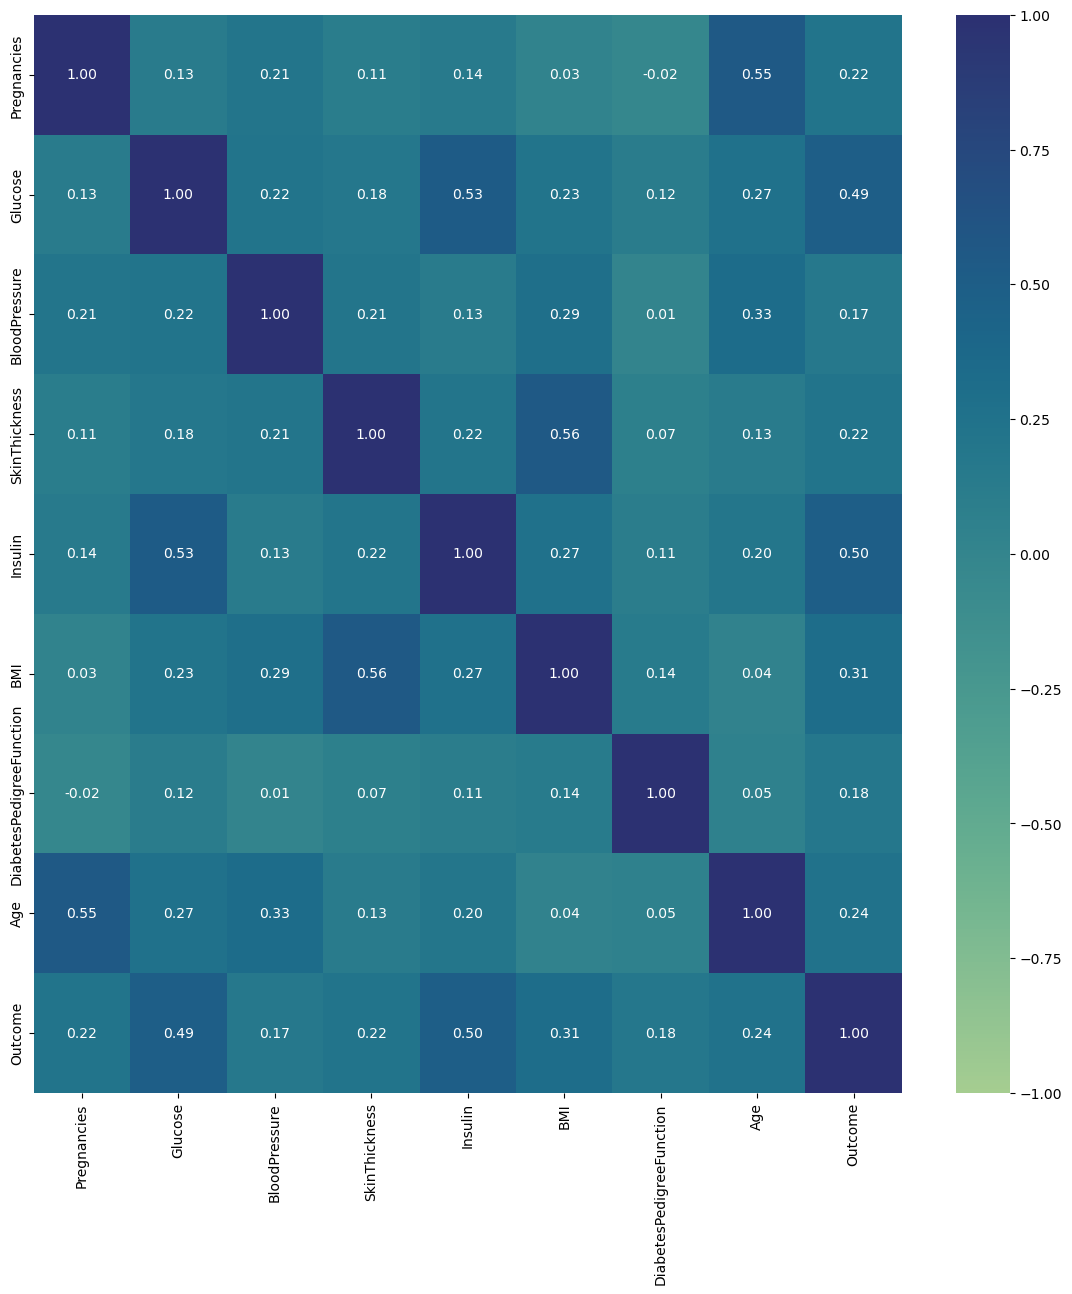

In [41]:
plt.figure(figsize=(14,14))
heatmap = sns.heatmap(data=corr,vmin=-1,vmax=1,cmap=sns.color_palette("crest", as_cmap=True),annot=True,fmt=".2f")
heatmap.get_figure().savefig("korelasyon_heatmap.png")
plt.show()

In [42]:
def Corr_analys(dataframe,figsize=(14,14),save=True):
    corr = dataframe.corr()
    print(corr)
    
    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(data = corr,vmin = -1,vmax = 1,annot = True,cmap = sns.color_palette("crest", as_cmap=True),fmt=".2f")
    plt.show()
    
    if save:
        heatmap.get_figure().savefig("korelasyon_heatmap.png")

                          Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DiabetesPedigreeFunction  Age  Outcome
Pregnancies                      1.00     0.13           0.21           0.11     0.14 0.03                     -0.02 0.55     0.22
Glucose                          0.13     1.00           0.22           0.18     0.53 0.23                      0.12 0.27     0.49
BloodPressure                    0.21     0.22           1.00           0.21     0.13 0.29                      0.01 0.33     0.17
SkinThickness                    0.11     0.18           0.21           1.00     0.22 0.56                      0.07 0.13     0.22
Insulin                          0.14     0.53           0.13           0.22     1.00 0.27                      0.11 0.20     0.50
BMI                              0.03     0.23           0.29           0.56     0.27 1.00                      0.14 0.04     0.31
DiabetesPedigreeFunction        -0.02     0.12           0.01           0.07     0.

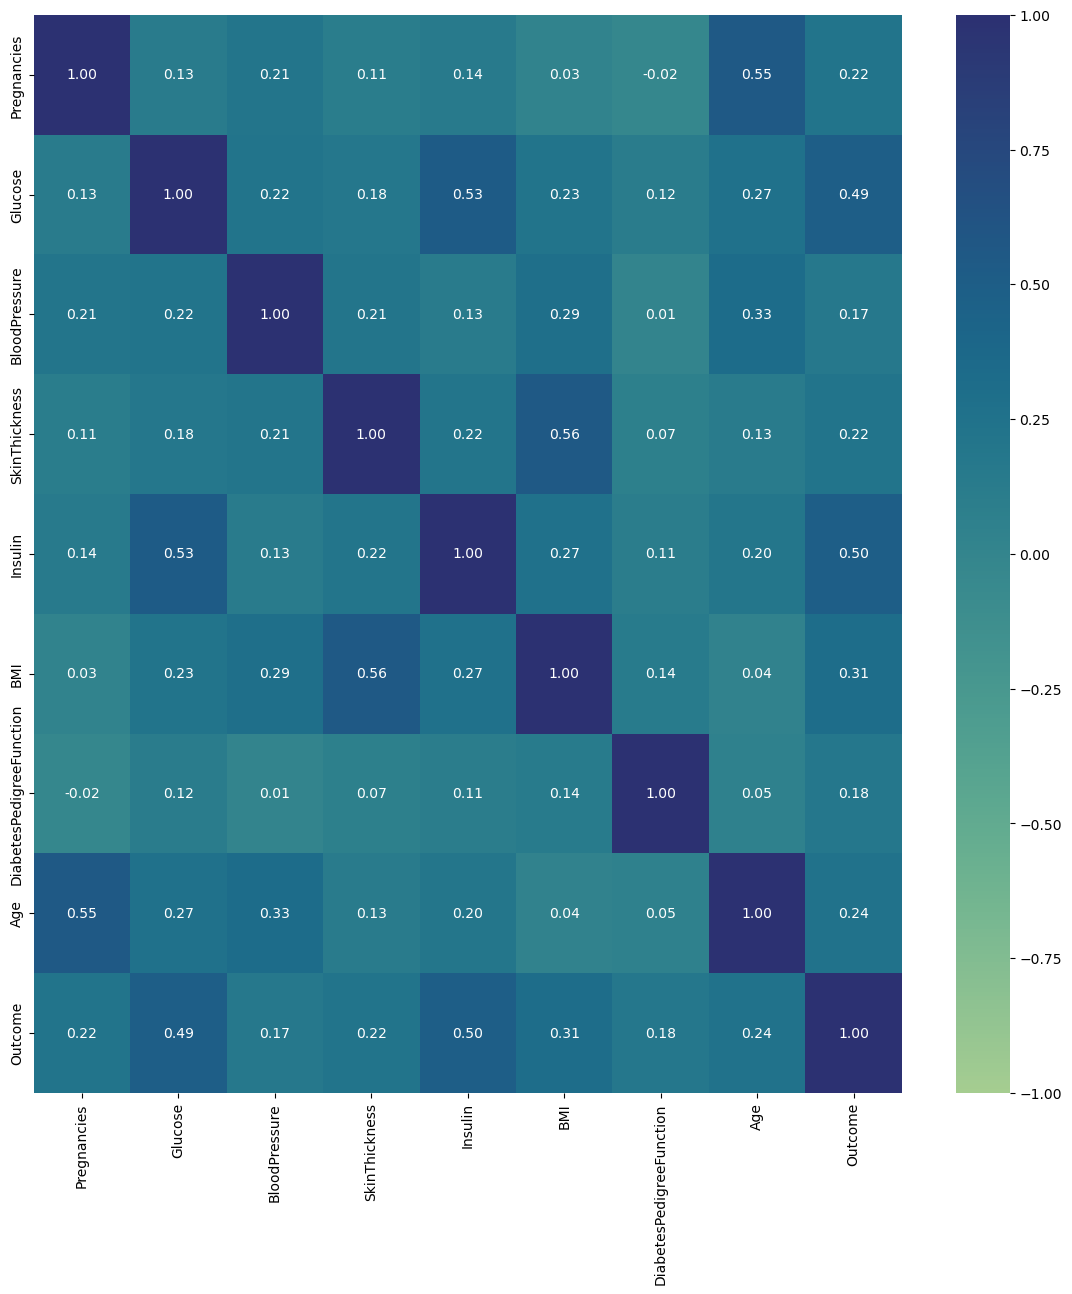

In [43]:
Corr_analys(df)

In [44]:
df["New_cat_age"] = pd.cut(df["Age"],bins=[18,24,30,50,70],labels=["young","adult","get_aged","senior"])

In [45]:
df.loc[df["BMI"] <= 15,"New_cat_bmi"] = "very_underweight"
df.loc[((df["BMI"] > 15) & (df["BMI"] <= 19)),"New_cat_bmi"] = "underweight"
df.loc[((df["BMI"] > 19) & (df["BMI"] <= 25)),"New_cat_bmi"] = "normal"
df.loc[((df["BMI"] > 25) & (df["BMI"] <= 30)),"New_cat_bmi"] = "fat"
df.loc[((df["BMI"] > 30) & (df["BMI"] <= 35)),"New_cat_bmi"] = "obese"
df.loc[df["BMI"] > 35,"New_cat_bmi"] = "really_obese"

In [46]:
df["GI_ratio"] = df["Glucose"] / df["Insulin"]

In [47]:
df.loc[((df["New_cat_age"] == "young") & (df["SkinThickness"] >= 31)),"New_skin_age"] = "overfat"
df.loc[((df["New_cat_age"] == "young") & ((df["SkinThickness"] < 31) & (df["SkinThickness"] >= 25))),"New_skin_age"] = "average"
df.loc[((df["New_cat_age"] == "young") & ((df["SkinThickness"] < 25) & (df["SkinThickness"] >= 20))),"New_skin_age"] = "ideal"
df.loc[((df["New_cat_age"] == "young") & (df["SkinThickness"] < 20)),"New_skin_age"] = "lean"

In [48]:
df.loc[((df["New_cat_age"] == "adult") & (df["SkinThickness"] >= 32.5)),"New_skin_age"] = "overfat"
df.loc[((df["New_cat_age"] == "adult") & ((df["SkinThickness"] < 32.5) & (df["SkinThickness"] >= 26))),"New_skin_age"] = "average"
df.loc[((df["New_cat_age"] == "adult") & ((df["SkinThickness"] < 26) & (df["SkinThickness"] >= 21))),"New_skin_age"] = "ideal"
df.loc[((df["New_cat_age"] == "adult") & (df["SkinThickness"] < 21)),"New_skin_age"] = "lean"

In [49]:
df.loc[((df["New_cat_age"] == "get_aged") & (df["SkinThickness"] >= 33.2)),"New_skin_age"] = "overfat"
df.loc[((df["New_cat_age"] == "get_aged") & ((df["SkinThickness"] < 33.2) & (df["SkinThickness"] >= 28))),"New_skin_age"] = "average"
df.loc[((df["New_cat_age"] == "get_aged") & ((df["SkinThickness"] < 28) & (df["SkinThickness"] >= 21.5))),"New_skin_age"] = "ideal"
df.loc[((df["New_cat_age"] == "get_aged") & (df["SkinThickness"] < 21.5)),"New_skin_age"] = "lean"

In [50]:
df.loc[((df["New_cat_age"] == "senior") & (df["SkinThickness"] >= 36)),"New_skin_age"] = "overfat"
df.loc[((df["New_cat_age"] == "senior") & ((df["SkinThickness"] < 36) & (df["SkinThickness"] >= 30))),"New_skin_age"] = "average"
df.loc[((df["New_cat_age"] == "senior") & ((df["SkinThickness"] < 30) & (df["SkinThickness"] >= 25))),"New_skin_age"] = "ideal"
df.loc[((df["New_cat_age"] == "senior") & (df["SkinThickness"] < 25)),"New_skin_age"] = "lean"

In [51]:
df["New_preg_age_ratio"] = df["Pregnancies"] / df["Age"]

In [52]:
df["New_skin_bmi"] = df["SkinThickness"] * df["BMI"]

In [53]:
cat_cols,num_cols,cat_but_car = grab_col_names(df)

cat_cols : 4
num_cols : 11
cat_but_car : 0
num_but_cat : 2


In [54]:
cat_cols = [col for col in cat_cols if col != "Outcome"]
cat_cols

['New_cat_bmi', 'New_skin_age', 'New_cat_age']

In [55]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'GI_ratio',
 'New_preg_age_ratio',
 'New_skin_bmi']

In [56]:
def one_hot_encoder(dataframe,cat_cols,drop_first=True):
    dataframe = pd.get_dummies(data=dataframe,columns=cat_cols,drop_first=drop_first)
    return dataframe

In [57]:
df = one_hot_encoder(df,cat_cols)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,GI_ratio,New_preg_age_ratio,New_skin_bmi,New_cat_bmi_normal,New_cat_bmi_obese,New_cat_bmi_really_obese,New_cat_bmi_underweight,New_skin_age_ideal,New_skin_age_lean,New_skin_age_overfat,New_cat_age_adult,New_cat_age_get_aged,New_cat_age_senior
0,6.00,148.00,72.00,35.00,206.85,33.60,0.63,50.00,1,0.72,0.12,1176.00,0,1,0,0,0,0,1,0,1,0
1,1.00,85.00,66.00,29.00,130.29,26.60,0.35,31.00,0,0.65,0.03,771.40,0,0,0,0,0,0,0,0,1,0
2,8.00,183.00,64.00,29.15,206.85,23.30,0.67,32.00,1,0.88,0.25,679.27,1,0,0,0,0,0,0,0,1,0
3,1.00,89.00,66.00,23.00,94.00,28.10,0.17,21.00,0,0.95,0.05,646.30,0,0,0,0,1,0,0,0,0,0
4,0.00,137.00,40.00,35.00,168.00,43.10,1.20,33.00,1,0.82,0.00,1508.50,0,0,1,0,0,0,1,0,1,0


In [58]:
ss = StandardScaler()
df[num_cols] = ss.fit_transform(df[num_cols])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,GI_ratio,New_preg_age_ratio,New_skin_bmi,New_cat_bmi_normal,New_cat_bmi_obese,New_cat_bmi_really_obese,New_cat_bmi_underweight,New_skin_age_ideal,New_skin_age_lean,New_skin_age_overfat,New_cat_age_adult,New_cat_age_get_aged,New_cat_age_senior
0,0.65,0.87,-0.03,0.82,0.82,0.18,0.59,1.45,1,-0.37,0.15,0.54,0,1,0,0,0,0,1,0,1,0
1,-0.85,-1.21,-0.55,0.01,-0.31,-0.87,-0.38,-0.19,0,-0.45,-0.93,-0.49,0,0,0,0,0,0,0,0,1,0
2,1.25,2.02,-0.72,0.03,0.82,-1.37,0.75,-0.10,1,-0.14,1.75,-0.73,1,0,0,0,0,0,0,0,1,0
3,-0.85,-1.07,-0.55,-0.79,-0.85,-0.64,-1.02,-1.05,0,-0.05,-0.74,-0.81,0,0,0,0,1,0,0,0,0,0
4,-1.15,0.50,-2.77,0.82,0.24,1.61,2.60,-0.02,1,-0.23,-1.33,1.39,0,0,1,0,0,0,1,0,1,0


In [59]:
"""
y = df["Outcome"]
X= df.drop(["Outcome"],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=17)
LogisticRegressionModel = LogisticRegression(random_state=41)
LogisticRegressionModel.fit(X_train,y_train)
y_pred = LogisticRegressionModel.predict(X_test)
accuracy_score(y_pred,y_test) 
"""

'\ny = df["Outcome"]\nX= df.drop(["Outcome"],axis=1)\nX_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=17)\nLogisticRegressionModel = LogisticRegression(random_state=41)\nLogisticRegressionModel.fit(X_train,y_train)\ny_pred = LogisticRegressionModel.predict(X_test)\naccuracy_score(y_pred,y_test) \n'

In [60]:
y = df["Outcome"]
X= df.drop(["Outcome"],axis=1)
LogisticRegressionModel = LogisticRegression(random_state=41)
LogisticRegressionModel.fit(X,y)
y_pred = LogisticRegressionModel.predict(X)
accuracy_score(y,y_pred)

0.8177083333333334

In [61]:
def katsayilari_ciz(model, ozellikler, num=len(X), kaydet=False):
    katsayi_degerleri = model.coef_[0]
    ozellik_isimleri = ozellikler.columns
    ozellik_imp = pd.DataFrame({"Deger": katsayi_degerleri, "Ozellik": ozellik_isimleri})
    
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Deger", y="Ozellik", data=ozellik_imp.sort_values(by="Deger", ascending=False)[:num])
    plt.title("Ozellik Katsayilari")
    plt.tight_layout()
    plt.show(block=True)
    
    if kaydet:
        plt.savefig("katsayilar.png")

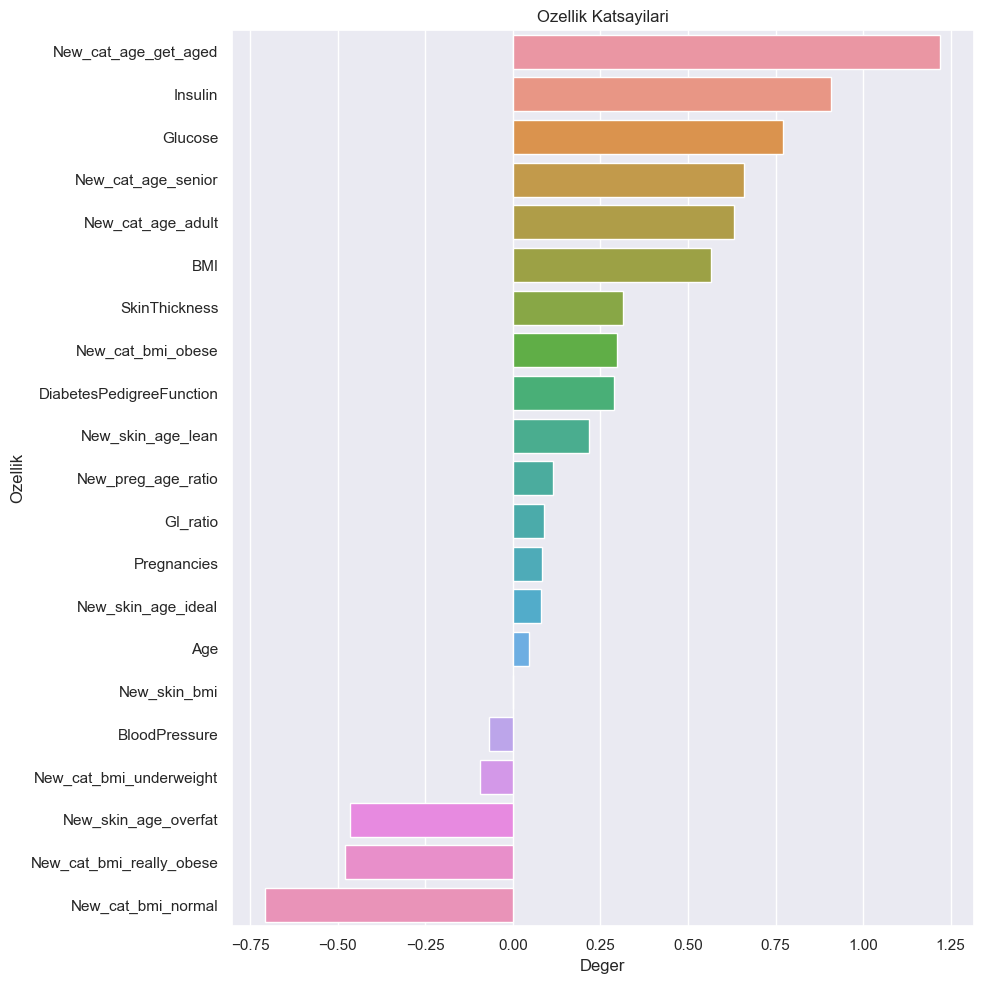

In [62]:
katsayilari_ciz(LogisticRegressionModel,X)

In [63]:
def plot_confusionMatrix(y,y_pred):
    acc = round(accuracy_score(y,y_pred),2)
    cm = confusion_matrix(y,y_pred)
    sns.heatmap(cm,annot=True,fmt=".0f")
    plt.xlabel("y_pred")
    plt.ylabel("y")
    plt.title(f"Accuracy Score {acc} ",size=10)
    plt.show()

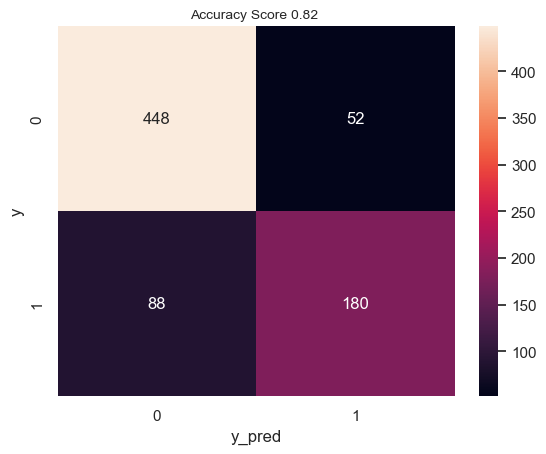

In [64]:
plot_confusionMatrix(y,y_pred)

In [65]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.86       500
           1       0.78      0.67      0.72       268

    accuracy                           0.82       768
   macro avg       0.81      0.78      0.79       768
weighted avg       0.81      0.82      0.81       768



In [66]:
"""
    accuarcy score = 1 ve 0 olarak tahmin ettigimiz degerlerin tüm veriye oranı %82 (448+180)/(448+52+88+180)
    precision = 1 olarak yaptıgımız tahminlerin % 78 oranında dogru bulmusuz  185/(185+54)
    recall = gercekte 1 olan degerlere yaptıgımız tahmin %67  185/(185+83)
    
    Bu sonuclar gösteriyorki logistic regression modeli diabet verileri uzerinde hic fena olmayan sonuclar cıkardı
"""

'\n    accuarcy score = 1 ve 0 olarak tahmin ettigimiz degerlerin tüm veriye oranı %82 (448+180)/(448+52+88+180)\n    precision = 1 olarak yaptıgımız tahminlerin % 78 oranında dogru bulmusuz  185/(185+54)\n    recall = gercekte 1 olan degerlere yaptıgımız tahmin %67  185/(185+83)\n    \n    Bu sonuclar gösteriyorki logistic regression modeli diabet verileri uzerinde hic fena olmayan sonuclar cıkardı\n'

In [67]:
y = df["Outcome"]
X= df.drop(["Outcome"],axis=1)
Knn_Model = KNeighborsClassifier()
Knn_Model.fit(X,y)
y_pred = Knn_Model.predict(X)
accuracy_score(y,y_pred)

C:\Users\Ali Can\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.8854166666666666

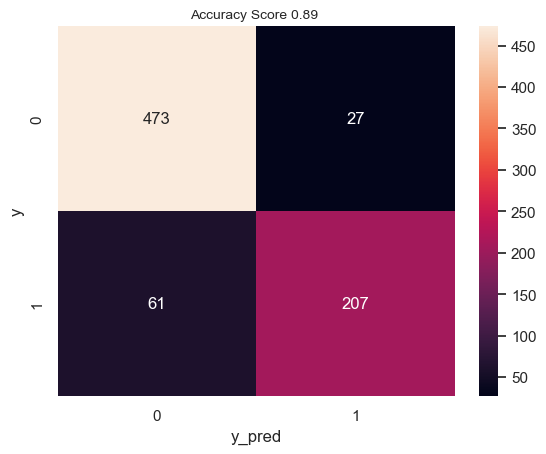

In [68]:
plot_confusionMatrix(y,y_pred)

In [69]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.91       500
           1       0.88      0.77      0.82       268

    accuracy                           0.89       768
   macro avg       0.89      0.86      0.87       768
weighted avg       0.89      0.89      0.88       768



In [1]:
"""
    accuarcy score = 1 ve 0 olarak tahmin ettigimiz degerlerin tüm veriye oranı %82 (473+207)/(473+27+61+207)
    precision = 1 olarak yaptıgımız tahminlerin % 88 oranında dogru bulmusuz  207/(207+27)
    recall = gercekte 1 olan degerlere yaptıgımız tahmin %77  207/(207+61)
    
    Bu sonuclar gösteriyorki Knn modeli  diabet verileri uzerinde harika sonuclar üretti
"""

'\n    accuarcy score = 1 ve 0 olarak tahmin ettigimiz degerlerin tüm veriye oranı %82 (473+207)/(473+27+61+207)\n    precision = 1 olarak yaptıgımız tahminlerin % 88 oranında dogru bulmusuz  207/(207+27)\n    recall = gercekte 1 olan degerlere yaptıgımız tahmin %77  207/(207+61)\n    \n    Bu sonuclar gösteriyorki Knn modeli  diabet verileri uzerinde harika sonuclar üretti\n'

In [71]:
y = df["Outcome"]
X= df.drop(["Outcome"],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
LogisticRegressionModel = LogisticRegression(random_state=41)
LogisticRegressionModel.fit(X_train,y_train)
y_pred = LogisticRegressionModel.predict(X_test)
accuracy_score(y_test,y_pred)

0.7395833333333334

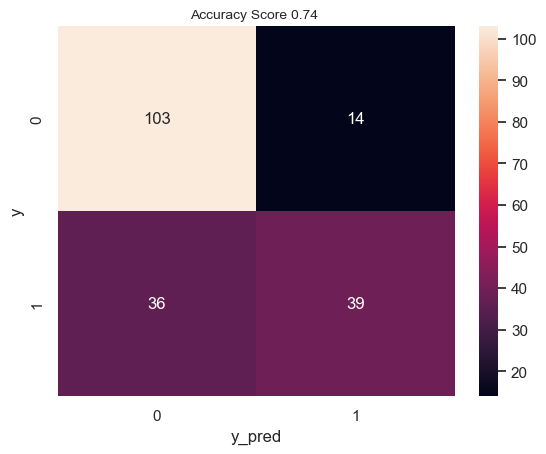

In [72]:
plot_confusionMatrix(y_test,y_pred)

In [73]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80       117
           1       0.74      0.52      0.61        75

    accuracy                           0.74       192
   macro avg       0.74      0.70      0.71       192
weighted avg       0.74      0.74      0.73       192



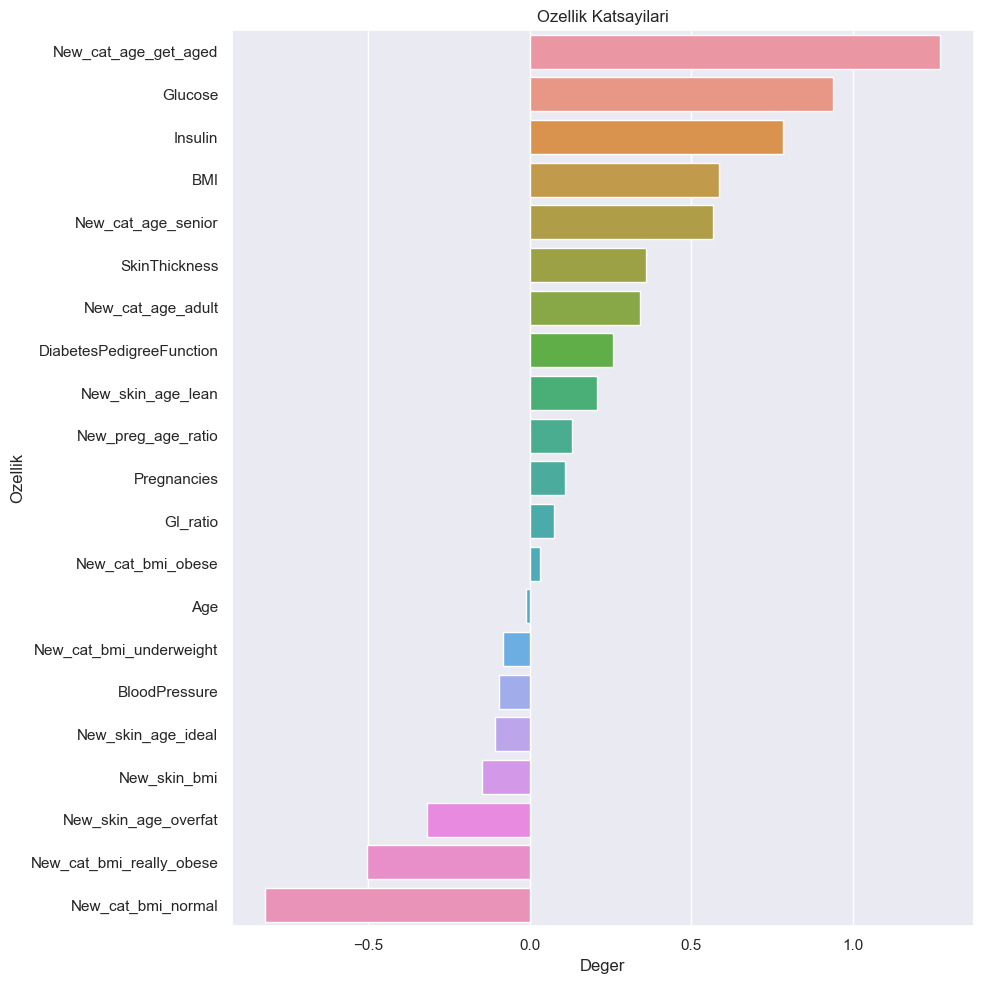

In [74]:
katsayilari_ciz(LogisticRegressionModel,X_train)

In [75]:
"""
        Train ve test olarak ayırdıgımız bu modelde basarı oranımızın düstüğünü gördük
     ve bazı degişkenlerin basarı üzerindeki etkisinin eksi yönde arttığını gözlemledik
     ancak veri setinin az sayida veriden olusması bunun üzerinde etkili olabilir
"""

'\n        Train ve test olarak ayırdıgımız bu modelde basarı oranımızın düstüğünü gördük\n     ve bazı degişkenlerin basarı üzerindeki etkisinin eksi yönde arttığını gözlemledik\n     ancak veri setinin az sayida veriden olusması bunun üzerinde etkili olabilir\n'

In [76]:
y = df["Outcome"]
X= df.drop(["Outcome"],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
Knn_Model = KNeighborsClassifier()
Knn_Model.fit(X_train,y_train)
y_pred = Knn_Model.predict(X_test)
accuracy_score(y_test,y_pred)

C:\Users\Ali Can\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.7916666666666666

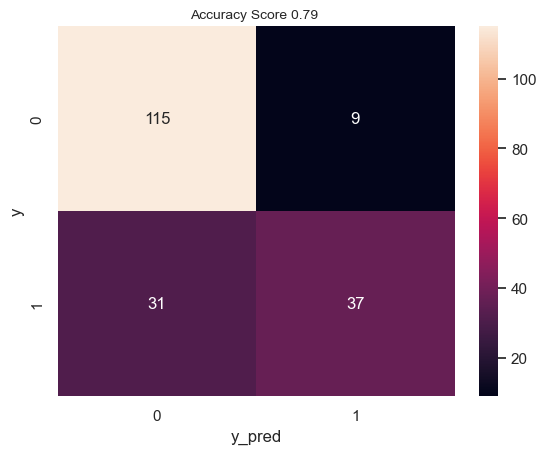

In [77]:
plot_confusionMatrix(y_test,y_pred)

In [78]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       124
           1       0.80      0.54      0.65        68

    accuracy                           0.79       192
   macro avg       0.80      0.74      0.75       192
weighted avg       0.79      0.79      0.78       192



In [79]:
"""
        Sonuç olarak Knn modelinin diabet verileri üzerinde olusturulan modeller neticesinde Logistic regression modelinden
    daha basarılı sonuçlar ürettigini sklearn ve veri görsellestirme kütüphanelerini kullanarak göstermiş olduk
"""

'\n        Sonuç olarak Knn modelinin diabet verileri üzerinde olusturulan modeller neticesinde Logistic regression modelinden\n    daha basarılı sonuçlar ürettigini sklearn ve veri görsellestirme kütüphanelerini kullanarak göstermiş olduk\n'

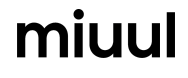